# Trabajo Práctico 5 Aprendizaje de Máquina  

Alumno: Leandro Borgnino

Profesores:
- Claudio Delrieux
- Manlio Miguel Massiris

## Consigna Trabajo Práctico  
En el trabajo práctico 5 se buscó aplicar algoritmos de clustering en un dataset de estadísticas de jugadores de fútbol del juego FIFA2022. La idea fue poder agrupar jugadores en base a sus habilidades. La hipótesis a priori es que según las habilidades la agrupación debiera ser similar a la posición en la que juegan en sus clubes.  
En este trabajo práctico se utilizará el mismo análisis del trabajo anterior pero aplicando técnicas de reducción de dimensionalidad para mejorar tanto la performance del modelo como para reducir la complejidad del mismo


### 1. Importar librerías

In [48]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

In [49]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

In [50]:
from sklearn import cluster, decomposition, preprocessing
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

### 2. Exploración de la base de datos 
La base de datos fue extraída de: https://www.kaggle.com/cashncarry/fifa-22-complete-player-dataset?select=players_fifa22.csv

In [51]:
!wget "https://drive.google.com/uc?export=download&id=1YbHoR0qA66l5dhe6Keal7w3tI8VevTEx" -O data.csv

--2021-12-11 16:18:36--  https://drive.google.com/uc?export=download&id=1YbHoR0qA66l5dhe6Keal7w3tI8VevTEx
Resolving drive.google.com (drive.google.com)... 173.194.69.139, 173.194.69.101, 173.194.69.113, ...
Connecting to drive.google.com (drive.google.com)|173.194.69.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-4k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/79ctr3dito5seecrdqeri9ub6rb24og8/1639239450000/04192308875186957499/*/1YbHoR0qA66l5dhe6Keal7w3tI8VevTEx?e=download [following]
--2021-12-11 16:18:38--  https://doc-10-4k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/79ctr3dito5seecrdqeri9ub6rb24og8/1639239450000/04192308875186957499/*/1YbHoR0qA66l5dhe6Keal7w3tI8VevTEx?e=download
Resolving doc-10-4k-docs.googleusercontent.com (doc-10-4k-docs.googleusercontent.com)... 172.217.218.132, 2a00:1450:4013:c08::84
Connecting to doc-10-4k-docs.googleusercontent.com (doc-1

In [52]:
df=pd.read_csv("data.csv")
df.head(4)

ID               Name                      FullName  Age  Height  \
0  158023           L. Messi                  Lionel Messi   34     170   
1  188545     R. Lewandowski            Robert Lewandowski   32     185   
2   20801  Cristiano Ronaldo  C. Ronaldo dos Santos Aveiro   36     187   
3  231747          K. Mbappé                 Kylian Mbappé   22     182   

   Weight                                          PhotoUrl Nationality  \
0      72  https://cdn.sofifa.com/players/158/023/22_60.png   Argentina   
1      81  https://cdn.sofifa.com/players/188/545/22_60.png      Poland   
2      83  https://cdn.sofifa.com/players/020/801/22_60.png    Portugal   
3      73  https://cdn.sofifa.com/players/231/747/22_60.png      France   

   Overall  Potential  Growth  TotalStats  BaseStats Positions BestPosition  \
0       93         93       0        2219        462  RW,ST,CF           RW   
1       92         92       0        2212        460        ST           ST   
2       91         91       0        2208        457     ST,LW           ST   
3       91         95       4        2175        470     ST,LW           ST   

                  Club   ValueEUR  WageEUR  ReleaseClause ClubPosition  \
0  Paris Saint-Germain   78000000   320000      144300000           RW   
1    FC Bayern München  119500000   270000      197200000           ST   
2    Manchester United   45000000   270000       83300000           ST   
3  Paris Saint-Germain  194000000   230000      373500000           ST   

   ContractUntil  ClubNumber  ClubJoined  OnLoad NationalTeam  \
0         2023.0        30.0        2021   False    Argentina   
1         2023.0         9.0        2014   False       Poland   
2         2023.0         7.0        2021   False     Portugal   
3         2022.0         7.0        2018   False       France   

  NationalPosition  NationalNumber PreferredFoot  IntReputation  WeakFoot  \
0               RW            10.0          Left              5         4   
1               ST             9.0         Right              5         4   
2               ST             7.0         Right              5         4   
3               LW            10.0         Right              4         4   

   SkillMoves AttackingWorkRate DefensiveWorkRate  PaceTotal  ShootingTotal  \
0           4            Medium               Low         85             92   
1           4              High            Medium         78             92   
2           5              High               Low         87             94   
3           5              High               Low         97             88   

   PassingTotal  DribblingTotal  DefendingTotal  PhysicalityTotal  Crossing  \
0            91              95              34                65        85   
1            79              85              44                82        71   
2            80              87              34                75        87   
3            80              92              36                77        78   

   Finishing  HeadingAccuracy  ShortPassing  Volleys  Dribbling  Curve  \
0         95               70            91       88         96     93   
1         95               90            85       89         85     79   
2         95               90            80       86         88     81   
3         93               72            85       83         93     80   

   FKAccuracy  LongPassing  BallControl  Acceleration  SprintSpeed  Agility  \
0          94           91           96            91           80       91   
1          85           70           88            77           79       77   
2          84           77           88            85           88       86   
3          69           71           91            97           97       92   

   Reactions  Balance  ShotPower  Jumping  Stamina  Strength  LongShots  \
0         94       95         86       68       72        69         94   
1         93       82         90       85       76        86       

Agrupamos las posiciones en 4: arqueros, defensores, mediocampistas, delanteros. Las posiciones "SUB" y "RES" no está claro qué representan, por lo que lo manejaremos como una categoría aparte y luego analizaremos a qué corresponden y si son relevantes de utilizar.

In [53]:
df.dropna(subset = ["ClubPosition"], inplace=True)

In [54]:
def get_position(row):
    if (row['ClubPosition'] == "CDM") | (row['ClubPosition'] == "LB") | (row['ClubPosition'] == "LWB") | (row['ClubPosition'] == "RB")  | (row['ClubPosition'] == "RWB") | (row['ClubPosition'] == "CB") :
        val = 'Defensor'
    elif ( (row['ClubPosition'] == "CM") | (row['ClubPosition'] == "LM") | (row['ClubPosition'] == "RM") | (row['ClubPosition'] == "CAM") ):
        val = 'Mediocampista'
    elif ((row['ClubPosition'] == "LW") | (row['ClubPosition'] == "LF") | (row['ClubPosition'] == "RW") | (row['ClubPosition'] == "RF") | (row['ClubPosition'] == "CF") | (row['ClubPosition'] == "ST") ):
      val = 'Delantero'
    elif (row['ClubPosition'] == "GK"):
      val = 'Arquero'
    elif (row['ClubPosition'] == "SUB"):
      val = 'SUB'
    elif (row['ClubPosition'] == "RES"):
      val = 'RES'
    return val

df_n=df[(df['Overall'] > 75)] # mejores jugadores
df_n['Position'] = df_n.apply(get_position, axis=1)

In [55]:
print(f'{len(df_n)} mejores jugadores con overall mayor a 75')

skills_ratings = ['PaceTotal', 'ShootingTotal',
                  'PassingTotal', 'DribblingTotal', 'DefendingTotal', 'PhysicalityTotal',
                  'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
                  'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                  'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
                  'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
                  'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
                  'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
                  'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']

print(f'{len(skills_ratings)} variables numéricas de desempeño según habilidad')

df_skills=df_n[skills_ratings]



1457 mejores jugadores con overall mayor a 75
40 variables numéricas de desempeño según habilidad


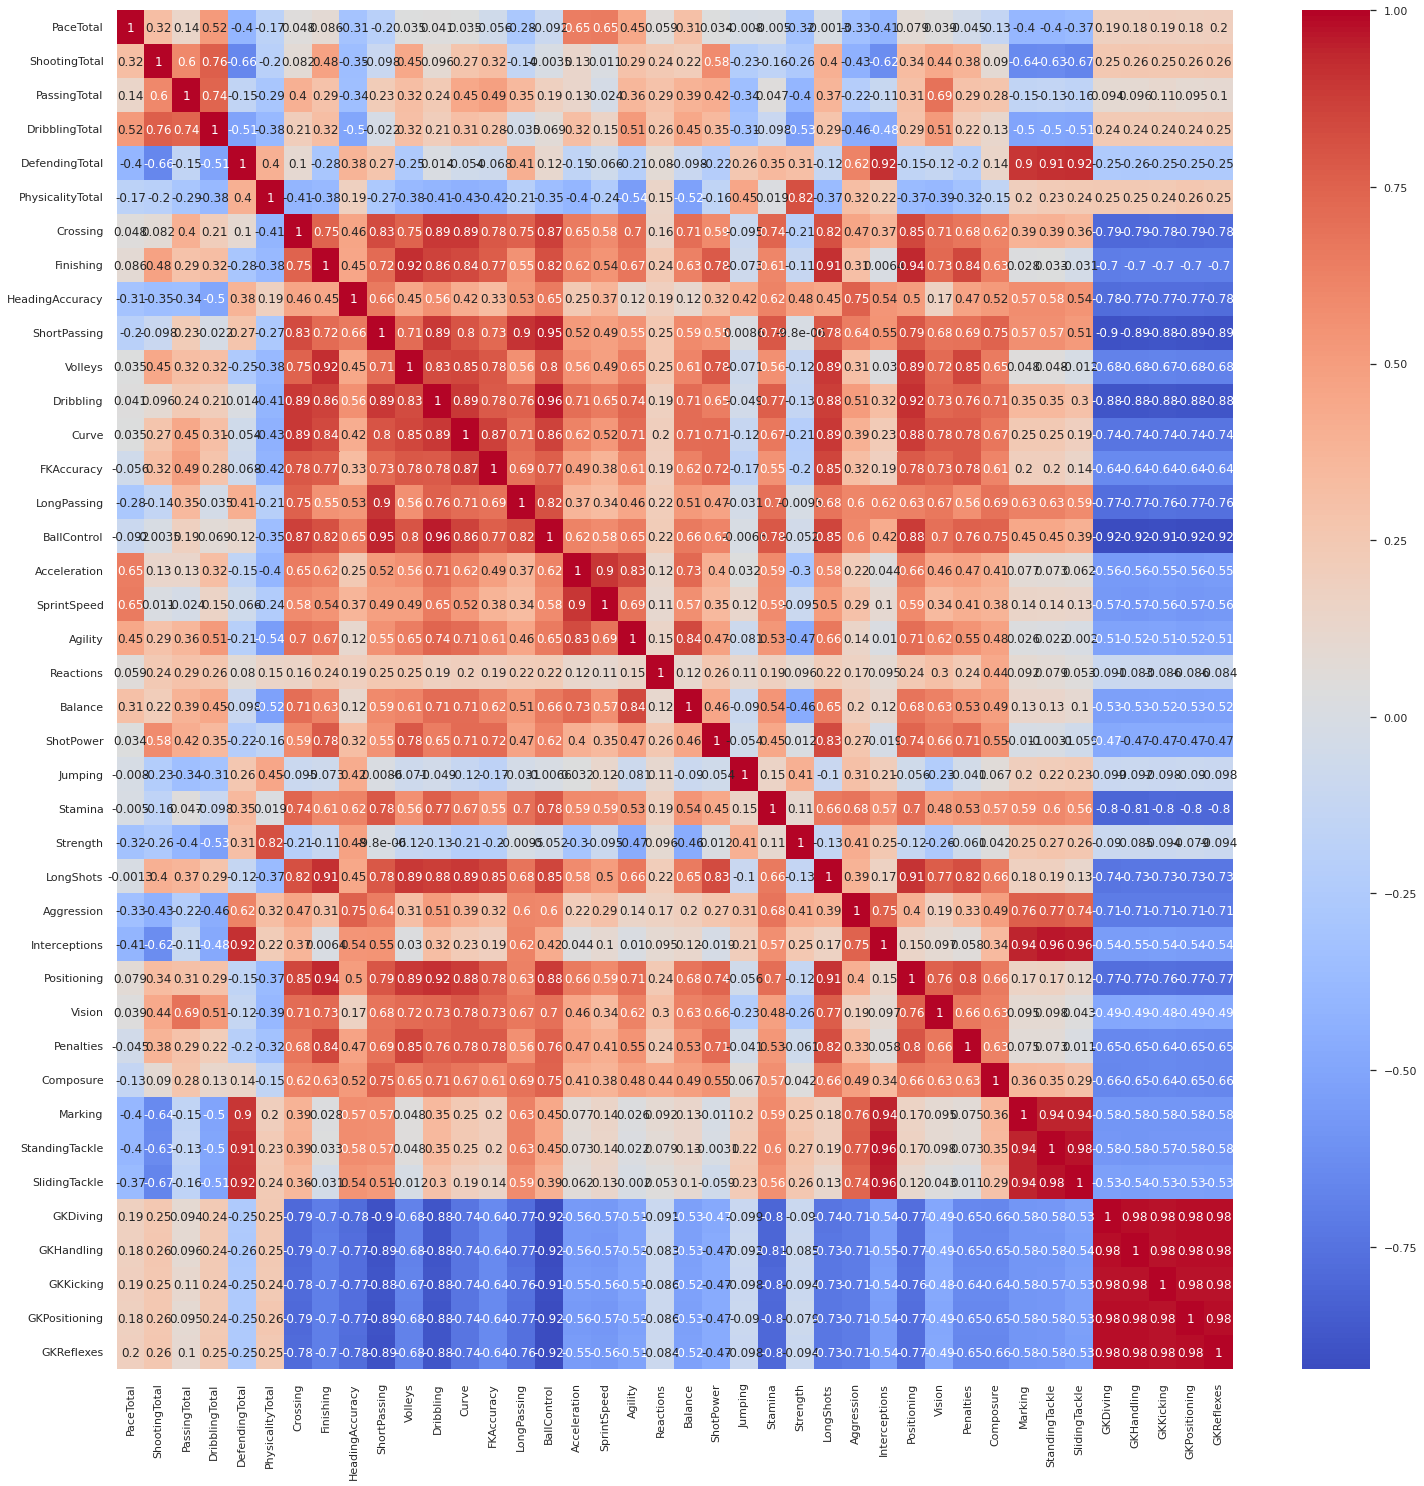

In [56]:
#Using Pearson Correlation
plt.figure(figsize=(25,25))
cor = df_skills.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm)
plt.show()

Mucha información puede sacarse de la correlación entre las variables de habilidad del dataset. Muchas están estrechamente relacionadas, por lo que utilizar una implica tener información sobre la otra, esto será importante para elegir las variables en el entrenamiento del modelo. También se puede ver con claridad que las skills "GK" tienen correlación alta solo con 

In [57]:
club_avg_overall=df.groupby("Club")["Overall"].mean().reset_index().sort_values("Overall",ascending=False)
club_avg_overall.head(8)

Club    Overall
368             Juventus  79.961538
470  Paris Saint-Germain  79.454545
358                Inter  78.724138
241    FC Bayern München  78.107143
412    Manchester United  78.000000
509       Real Madrid CF  77.757576
434               Napoli  77.500000
63              Atalanta  77.480000

### Visualización de Características de los jugadores

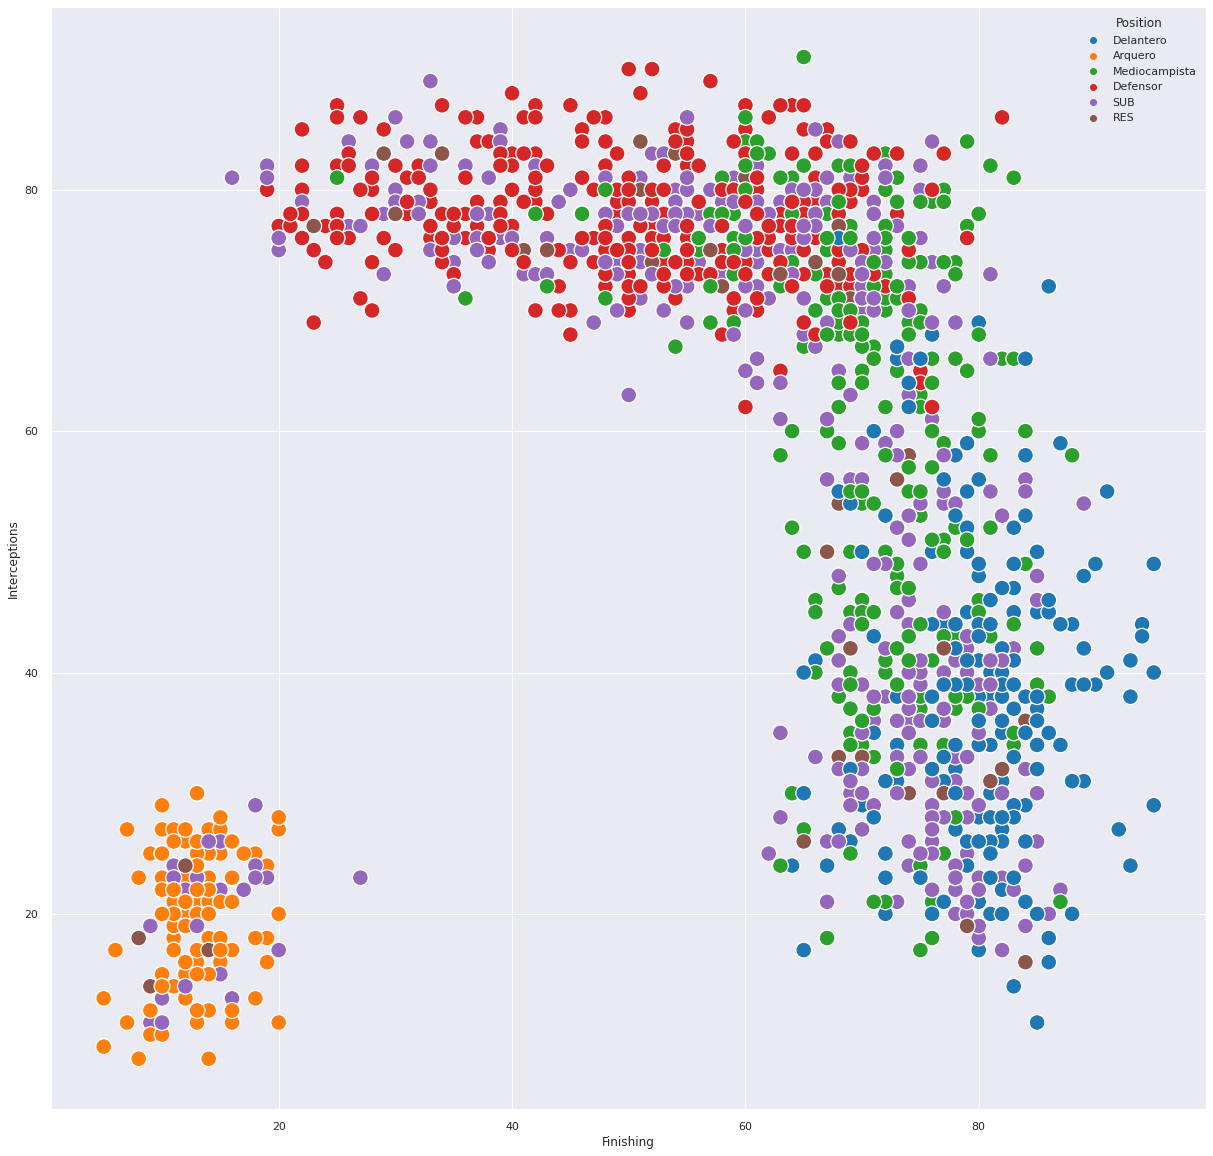

In [58]:
sns.set(rc={'figure.figsize':(20.7,20.27)})
#bool_crack=df_n["Overall"] > 85 #diferenciamos a los mejores jugadores

skill_1=skills_ratings[7]
skill_2=skills_ratings[27]

sns.scatterplot(x=skill_1,y=skill_2, hue='Position',data=df_n, s=250,palette="tab10")


Como podemos observar, las posiciones "SUB" y "RES" no tienen un grupo definido. Gracias a este análisis se puede inferir que SUB corresponde a "substitution" y RES a "jugador de reserva". Esto tiene sentido porque jugadores de reserva y suplentes están en todas las posiciones.

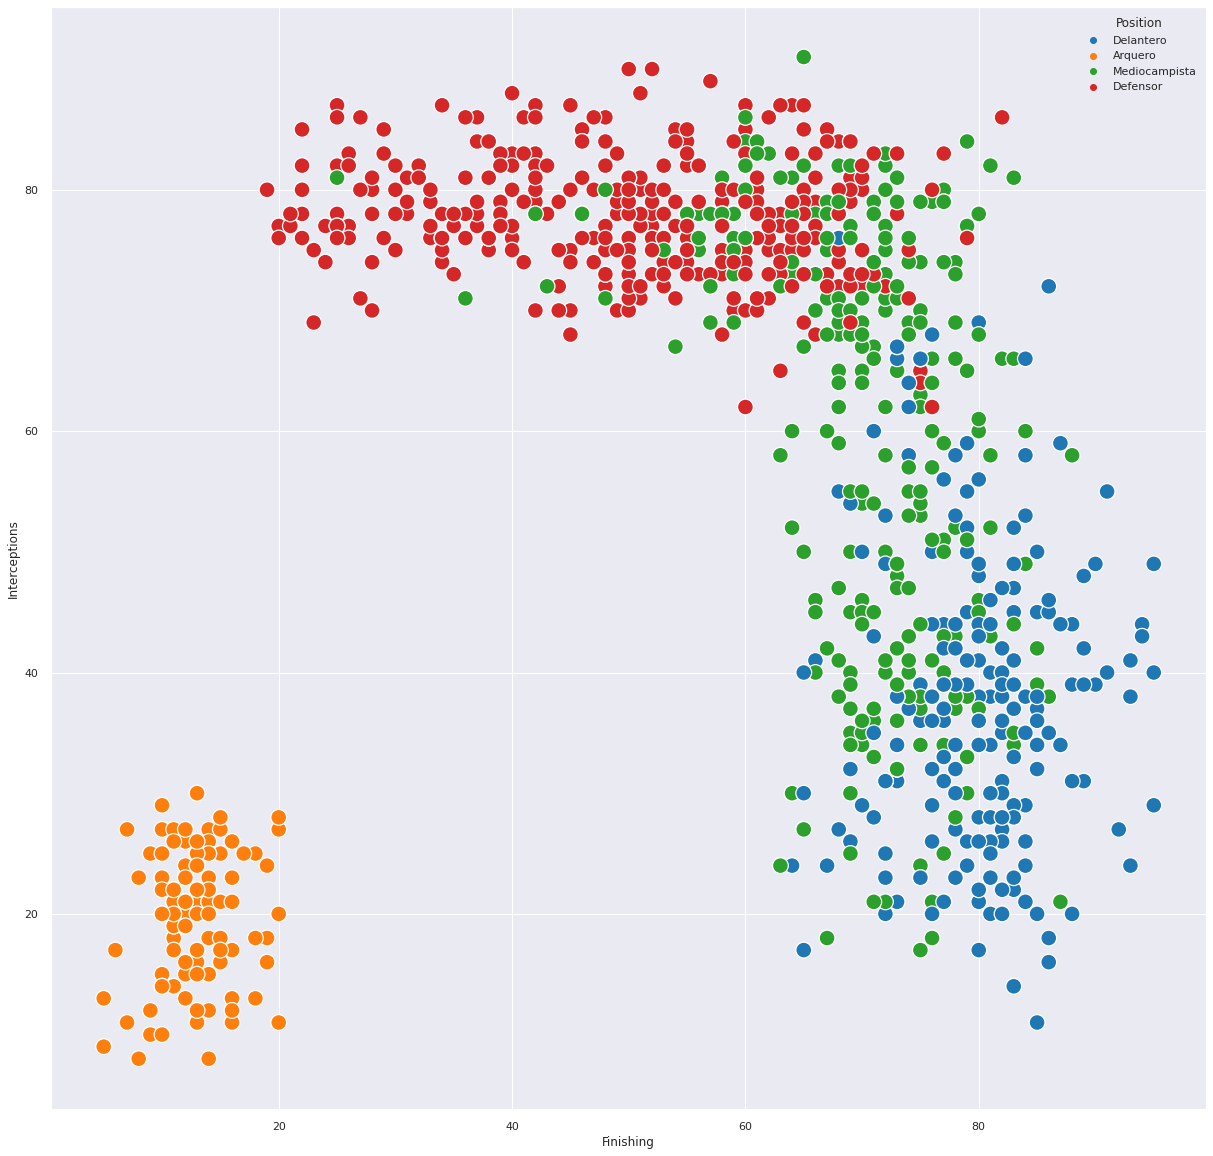

In [59]:
df_wo_sub_res = df_n[-( (df_n.Position == 'SUB') | (df_n.Position == 'RES'))]
df_skills=df_wo_sub_res[skills_ratings]
#bool_crack=df_n["Overall"] > 85 #diferenciamos a los mejores jugadores

skill_1=skills_ratings[7]
skill_2=skills_ratings[27]
sns.scatterplot(x=skill_1,y=skill_2, hue='Position',data=df_wo_sub_res, s=250,palette="tab10")

Podemos observar como se diferencian, con estas skills, los arqueros del resto de los jugadores (tienen valores bajos en las dos cosas). Luego, puede observarse que defensores y delanteros están bien separados. En cambio, los mediocampistas están mezclados entre todos los datos.

In [60]:
pairs_skills = [[9,14], [15,24], [34,9], [2,39]]

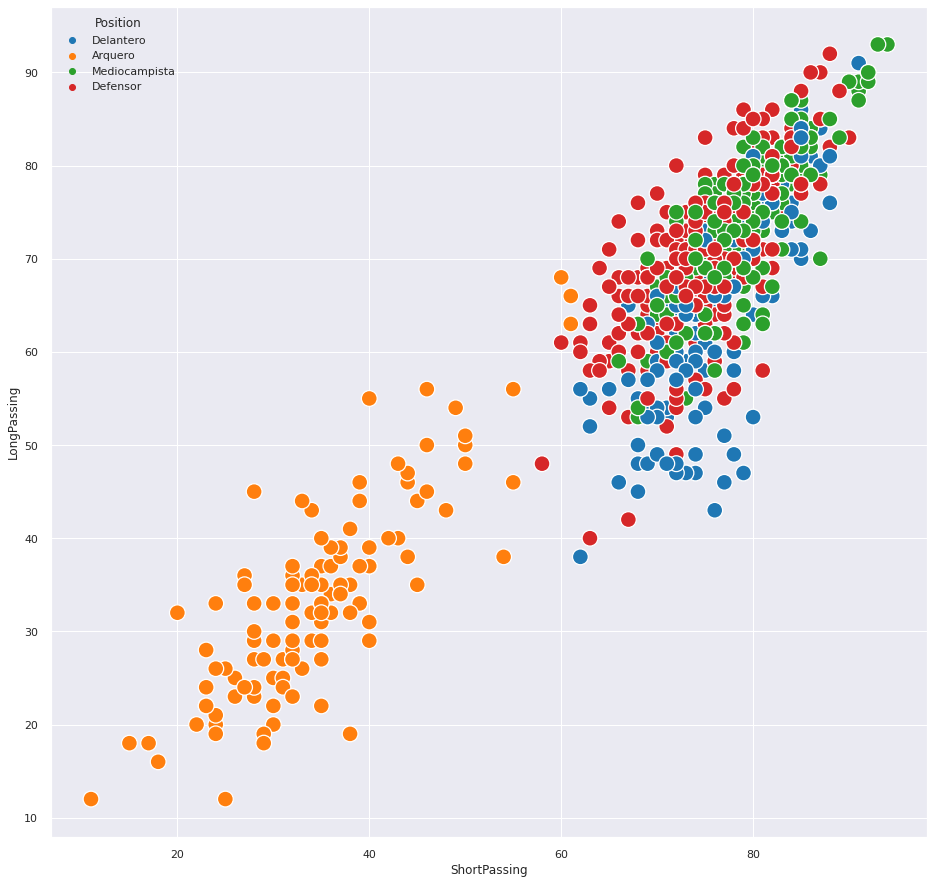

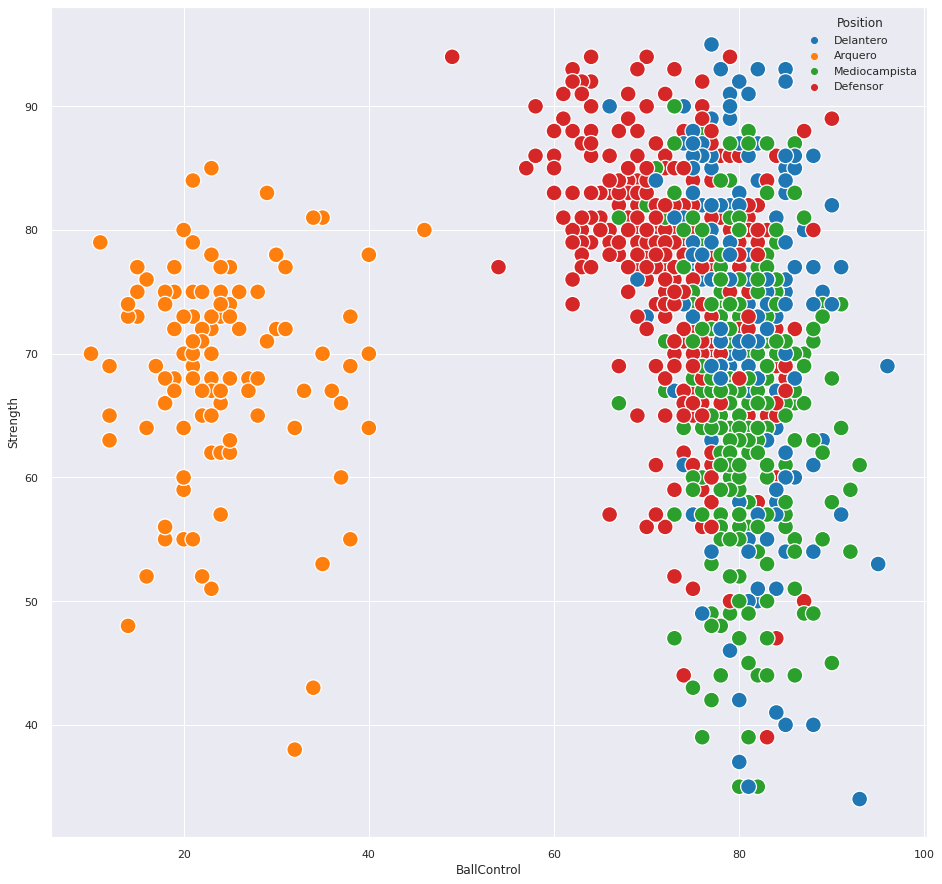

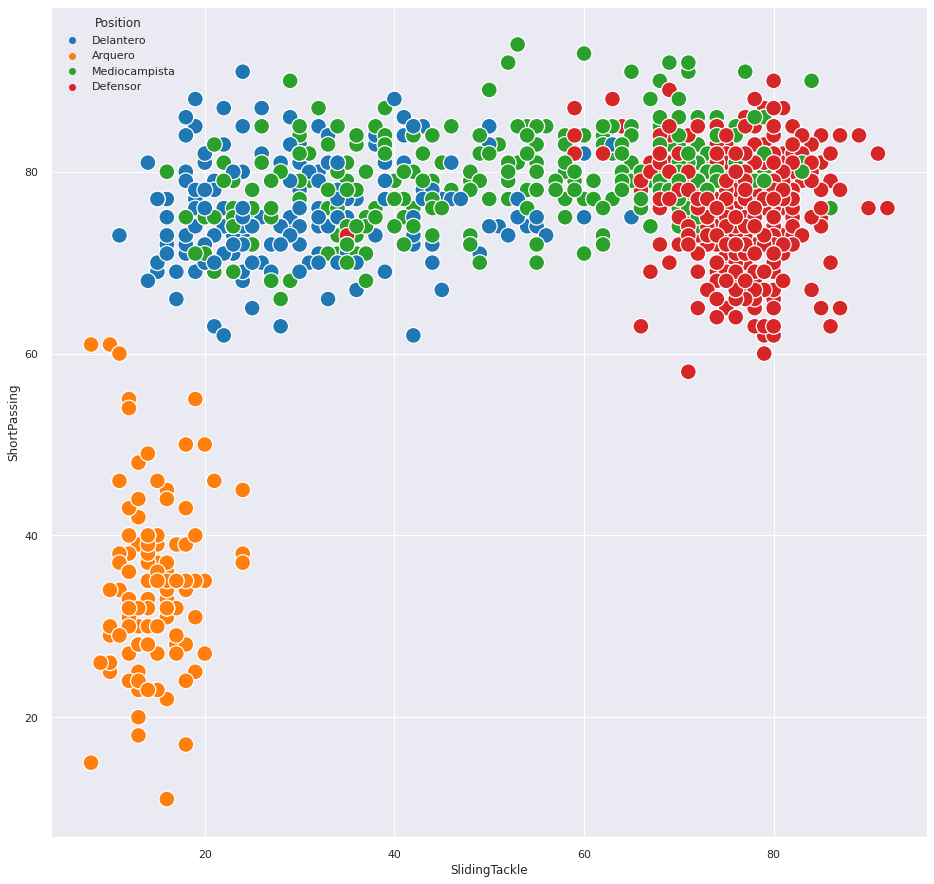

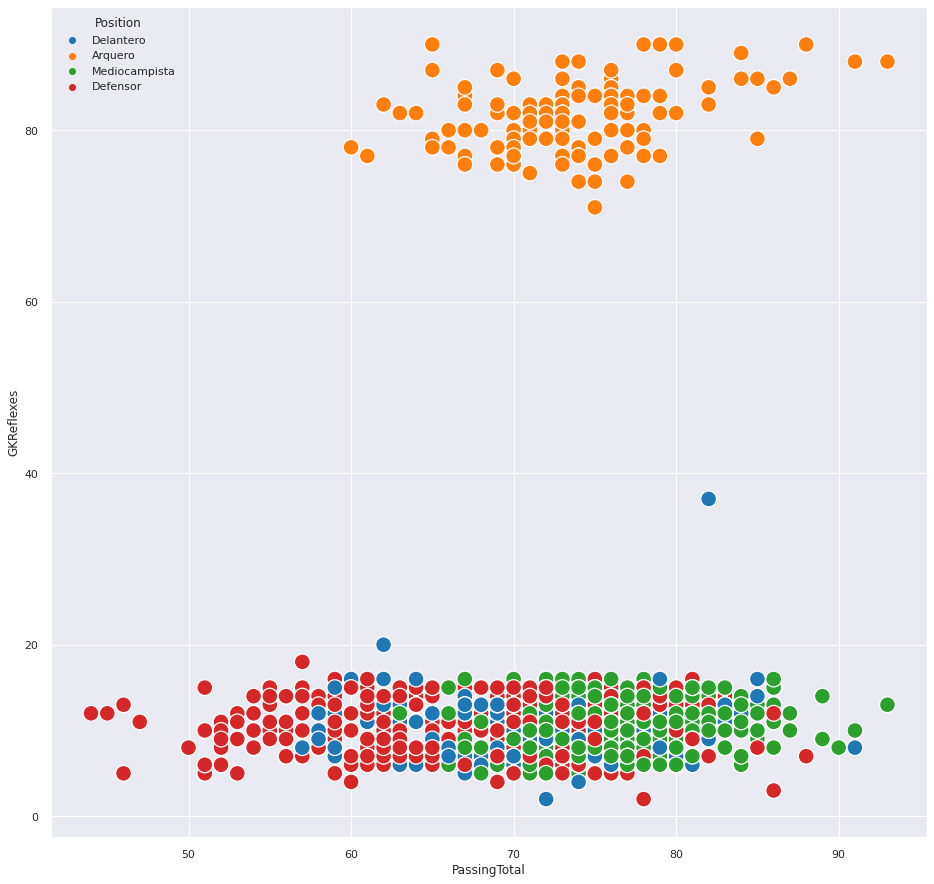

In [61]:
sns.set(rc={'figure.figsize':(15.7,15.27)})
for i in pairs_skills:
  skill_1=skills_ratings[i[0]]
  skill_2=skills_ratings[i[1]]
  sns.scatterplot(x=skill_1,y=skill_2, hue='Position',data=df_wo_sub_res, s=250,palette="tab10")
  plt.show()

En estos casos se pueden ver:  
1. Una correlación positiva de variables en el primer gráfico entre pasos cortos y largos (jugadores que pasan bien en general, tienen alto este valor)  
2. y 3. Otras variables a tener en cuenta para poder separar mediocampistas de los otros grupos.
4. Los arqueros son fácilmente separables usando las estadísticas de GK.

### Entrenamiento de Modelo de K Medias

Normalización de los datos

In [62]:
std_scale = preprocessing.MinMaxScaler().fit_transform(df_skills.values)
df_skills = pd.DataFrame(std_scale)

Es necesario definirle la cantidad de grupos/clusters (n_clusters), es un hiperparámetro del algoritmo.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

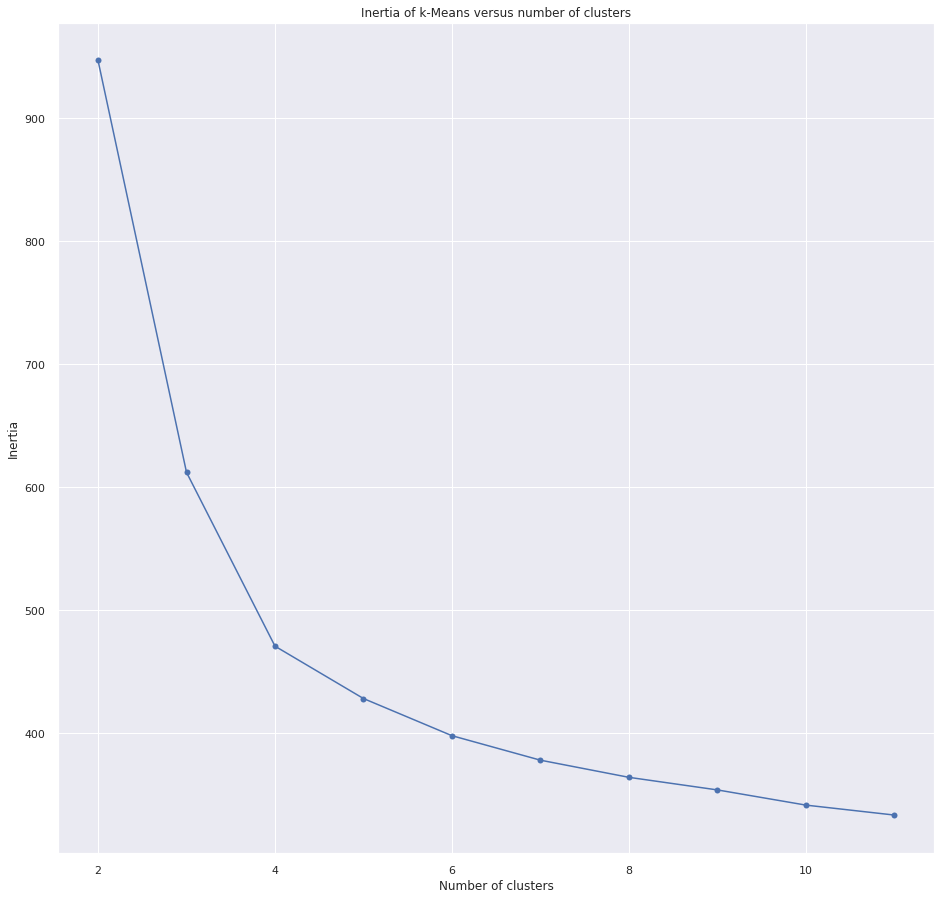

In [63]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i+2).fit(df_skills).inertia_ for i in range(10)]

from matplotlib import pyplot as plt
plt.plot(np.arange(2, 12), scores,'bo-')
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [64]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust, random_state=42)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster / Inertia: ', km.inertia_)

Suma de los cuadrados de las distancias al cluster / Inertia:  470.704120911041


In [65]:
df_clusters=df_wo_sub_res.copy()
df_clusters['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros lo forzamos')

df_clusters.groupby('kmeans').size()

Kmeans encontró:  4 clusters, nosotros lo forzamos


kmeans
0    181
1    326
2    117
3    364
dtype: int64

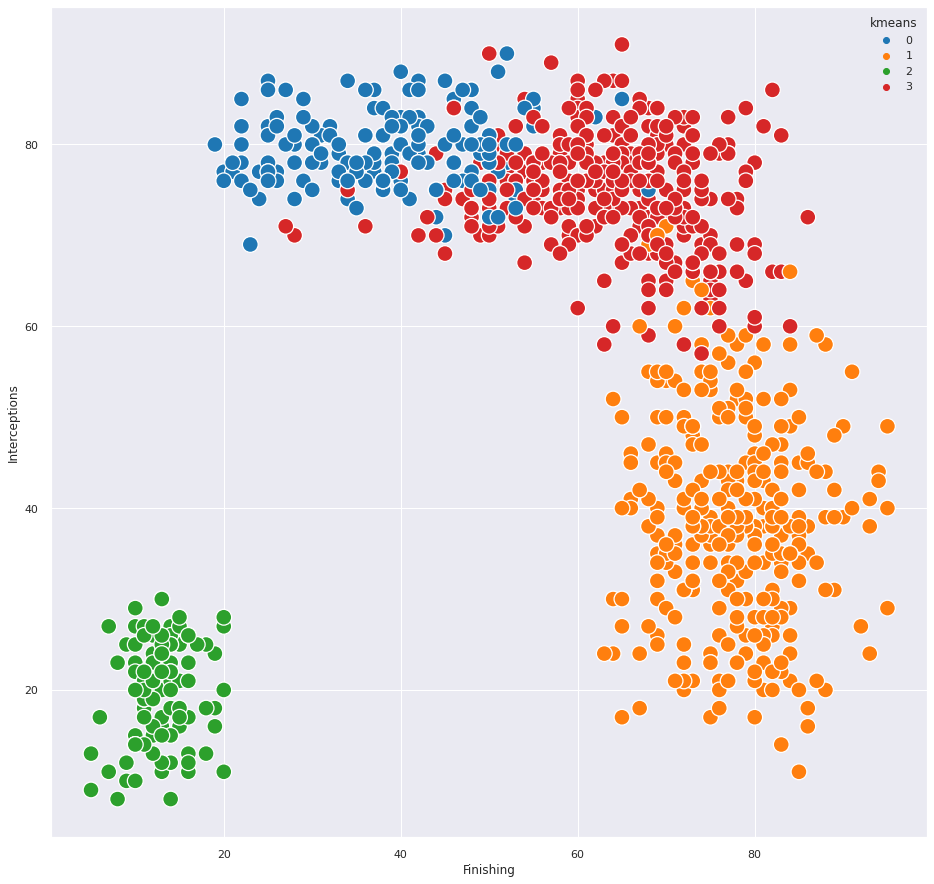

In [66]:
skill_1=skills_ratings[7]
skill_2=skills_ratings[27]
sns.scatterplot(x=skill_1,y=skill_2, hue='kmeans',data=df_clusters, s=250,palette="tab10")

Tomamos ejemplos de cada cluster

In [67]:
best_players_per_cluster=df_clusters.iloc[df_clusters.groupby(df_clusters['kmeans'])['Overall'].idxmax()][['kmeans','Name','ClubPosition','Overall']]
best_players_per_cluster

kmeans          Name ClubPosition  Overall
16       0   V. van Dijk           CB       89
0        1      L. Messi           RW       93
4        2      J. Oblak           GK       91
5        3  K. De Bruyne           CM       91

Calculamos las métricas de este modelo

In [68]:
codes = {0:'Delantero', 1:'Arquero', 2:'Defensor',3:'Mediocampista'}

In [69]:
df_clusters['kmeans'] = df_clusters['kmeans'].map(codes)

In [70]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn import metrics


def statistics_model(labels, model_labels):
  metricas = (metrics.homogeneity_score(labels, model_labels),
              metrics.completeness_score(labels, model_labels),
              metrics.v_measure_score   (labels, model_labels)) 
  print('Homogeneidad:\t%.3f\nCompletitud:\t%.3f\nV Measure:\t%.3f'%(metricas[0],metricas[1],metricas[2]))

  return metricas

metricas_km = statistics_model(df_clusters['ClubPosition'],df_clusters['kmeans'])

Homogeneidad:	0.395
Completitud:	0.752
V Measure:	0.518


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7faa078301d0>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=4, random_state=42))

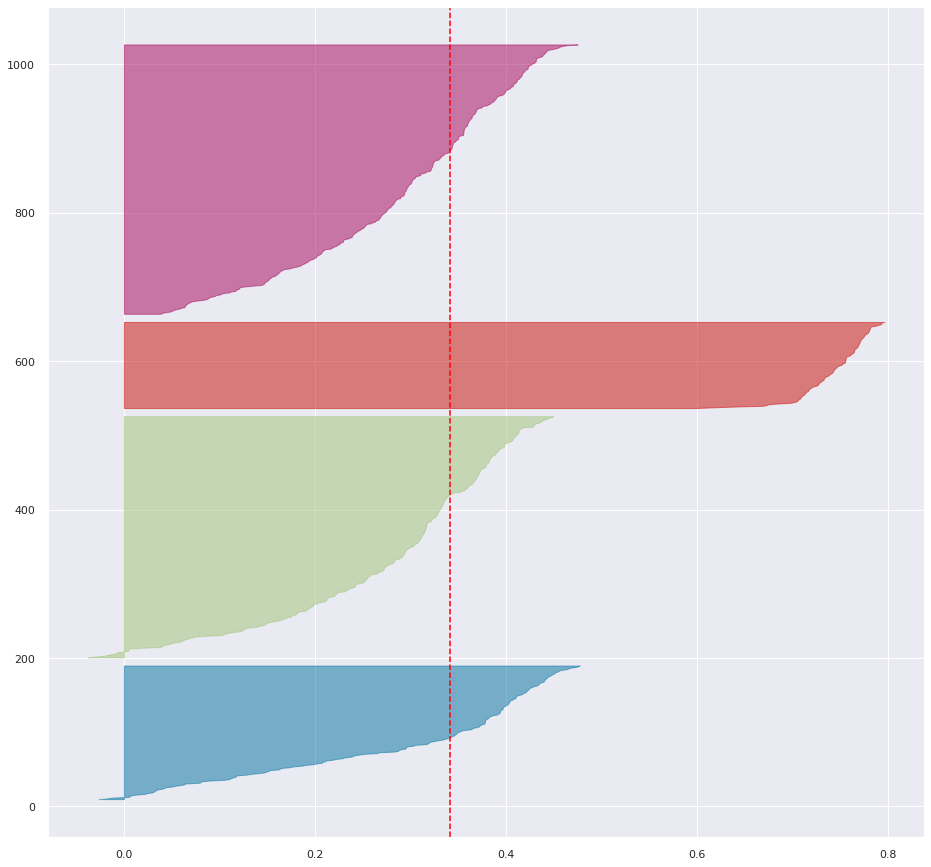

In [71]:
from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(df_skills)


### Spectral Clustering

In [72]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(
    n_clusters=4,
    eigen_solver=None,
    n_components=None,
    random_state=42,
    n_init=4,
    gamma=0.1,
    affinity='rbf',
    n_neighbors=4,
    eigen_tol=0.0,
    assign_labels='kmeans',
    degree=3,
    coef0=1,
    kernel_params=None,
    n_jobs=None)

In [73]:
sc.fit(df_skills)
# Recuperacion de etiquetas
clusters = sc.labels_

In [74]:
df_clusters['sc'] = sc.labels_ #clusters
print('Kmeans encontró: ', max(sc.labels_)+1, 'clusters, nosotros lo forzamos')

df_clusters.groupby('sc').size()

Kmeans encontró:  4 clusters, nosotros lo forzamos


sc
0    418
1    286
2    117
3    167
dtype: int64

In [75]:
best_players_per_cluster=df_clusters.iloc[df_clusters.groupby(df_clusters['sc'])['Overall'].idxmax()][['sc','Name','ClubPosition','Overall']]
best_players_per_cluster

sc          Name ClubPosition  Overall
5    0  K. De Bruyne           CM       91
0    1      L. Messi           RW       93
4    2      J. Oblak           GK       91
46   1     J. Sancho           LM       87

In [76]:
codes = {0:'Defensor', 1:'Arquero', 2:'Mediocampista',3:'Delantero'}

In [77]:
df_clusters['sc'] = df_clusters['sc'].map(codes)

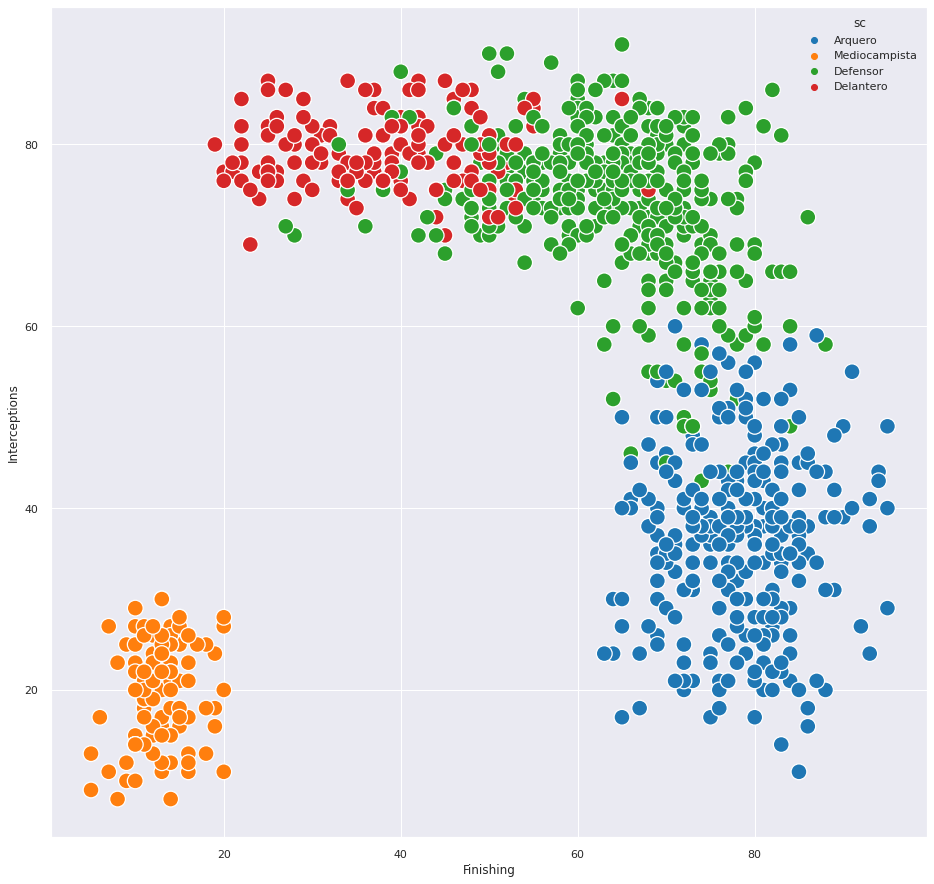

In [78]:
sns.set(rc={'figure.figsize':(15.7,15.27)})
skill_1=skills_ratings[7]
skill_2=skills_ratings[27]
sns.scatterplot(x=skill_1,y=skill_2, hue='sc',data=df_clusters, s=250,palette="tab10")

In [79]:
metricas_sc = statistics_model(df_clusters['ClubPosition'],df_clusters['sc'])

Homogeneidad:	0.375
Completitud:	0.726
V Measure:	0.494


Para n_clusters = 4 El silhouette_score promedio es : 0.33802412665723186


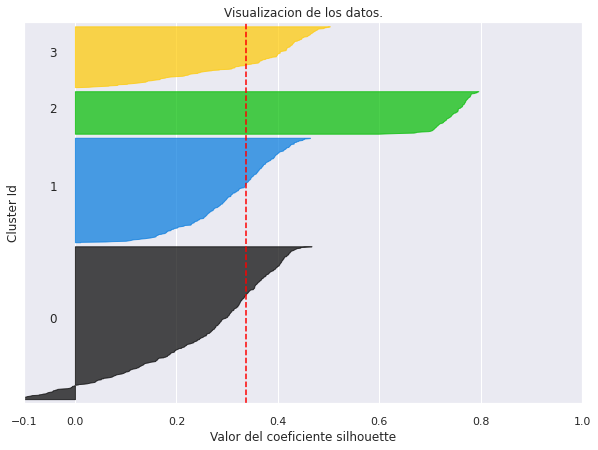

In [80]:
for i in range(1):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_skills) + (n_clust + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = sc
    cluster_labels = clusters

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_skills, cluster_labels)
    print("Para n_clusters =", n_clust,
          "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_skills, cluster_labels)

    y_lower = 10
    for i in range(n_clust):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clust)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("Valor del coeficiente silhouette")
    ax1.set_ylabel("Cluster Id")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

### Descomposición PCA

In [95]:
from sklearn import decomposition
pca=decomposition.PCA(n_components=2) #elegimos 2, 3 o 4 pero pueden ser más, 

print(df_skills.shape)
pca.fit(df_skills) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

X_projected=pca.transform(df_skills) #numpy array
print ('tamaño de los datos: ', X_projected.shape)

(988, 40)
proporción de varianza por componente:  [0.54411957 0.2317167 ]
proporción de varianza por componente acumulada:  [0.54411957 0.77583627]
tamaño de los datos:  (988, 2)


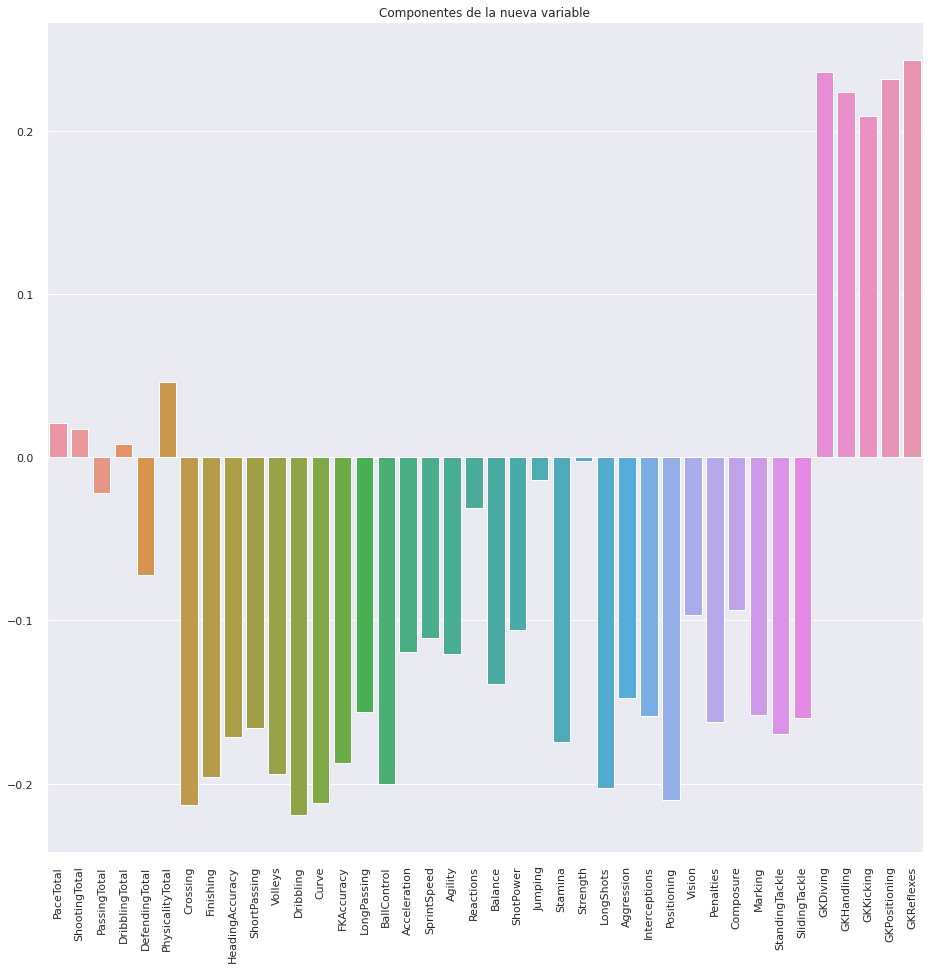

In [108]:
sns.barplot(skills_ratings,pca.components_[0])
plt.title("Componentes de la nueva variable")
plt.xticks(rotation=90)
plt.show()

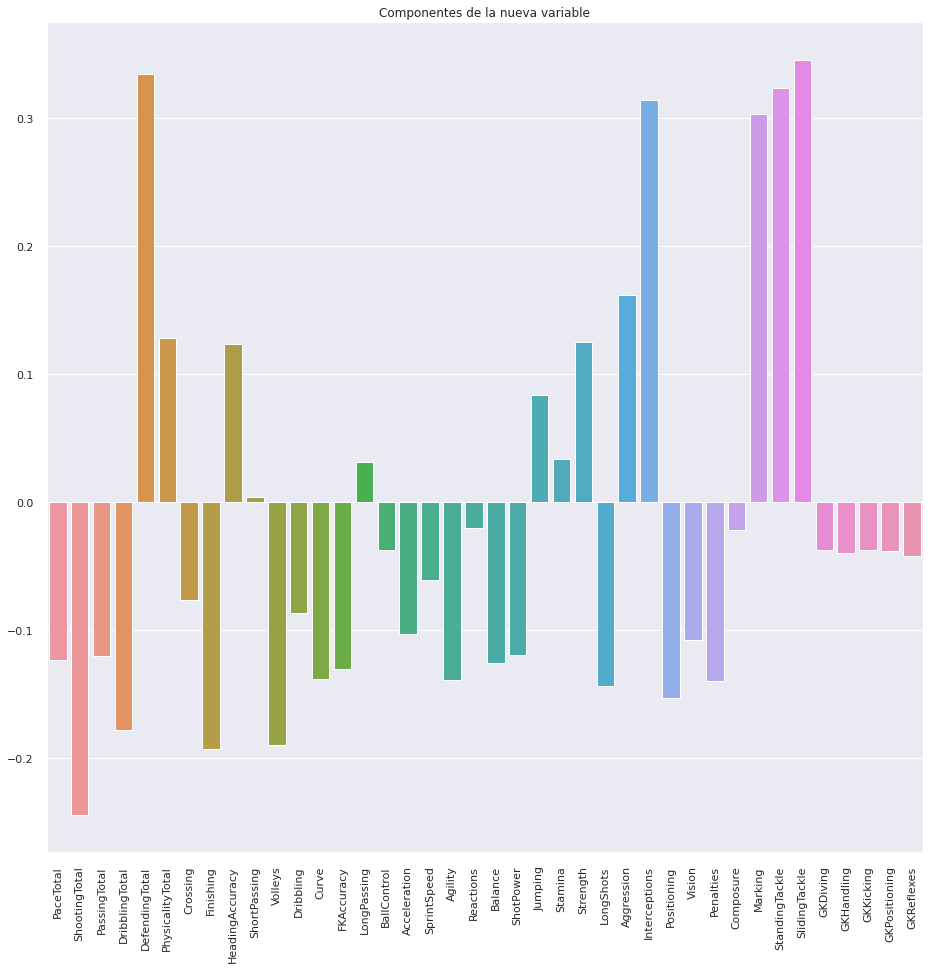

In [109]:
sns.barplot(skills_ratings,pca.components_[1])
plt.xticks(rotation=90)
plt.title("Componentes de la nueva variable")
plt.show()

In [82]:
# Número de clusters buscado
n_clust = 4

km_pca = KMeans(n_clusters=n_clust)
km_pca.fit(X_projected)

# Recuperacion de etiquetas
clusters = km_pca.labels_
print('Suma de los cuadrados de las distancias al cluster / Inertia: ', km_pca.inertia_)

Suma de los cuadrados de las distancias al cluster / Inertia:  86.39943534860986


In [83]:
df_clusters=df_wo_sub_res.copy()
df_clusters['kmeans_pca'] = km_pca.labels_ #clusters
print('Kmeans encontró: ', max(km_pca.labels_)+1, 'clusters, nosotros lo forzamos')

df_clusters.groupby('kmeans_pca').size()

Kmeans encontró:  4 clusters, nosotros lo forzamos


kmeans_pca
0    350
1    117
2    341
3    180
dtype: int64

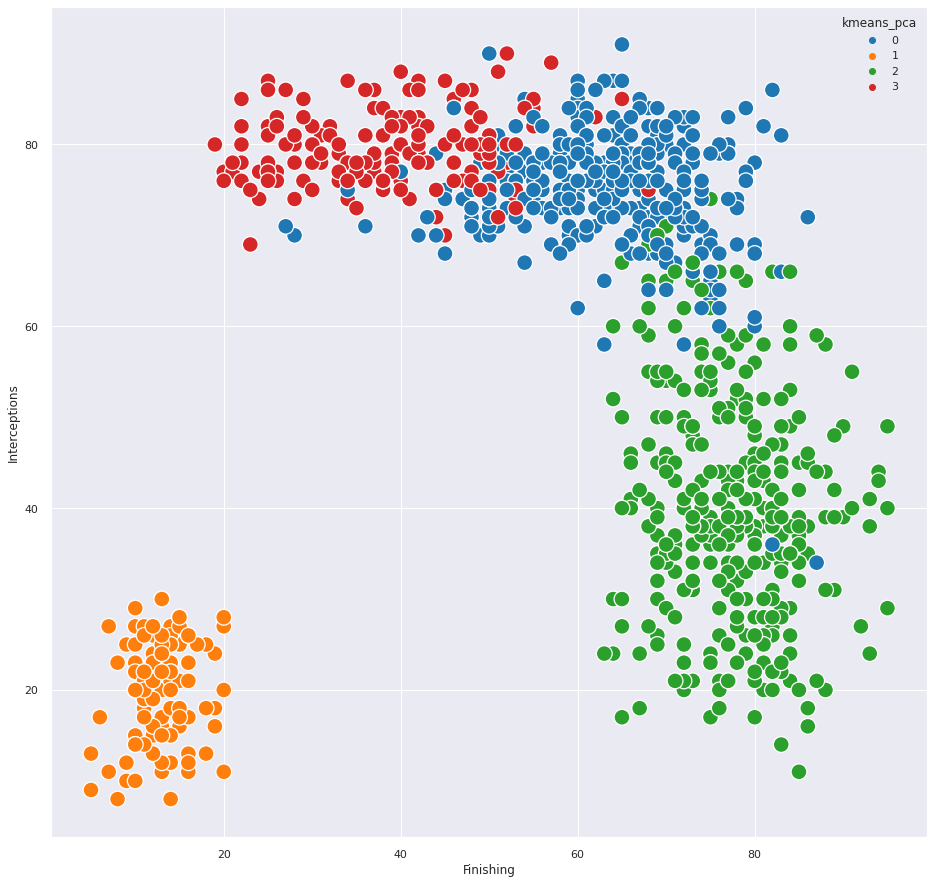

In [84]:
skill_1=skills_ratings[7]
skill_2=skills_ratings[27]
sns.scatterplot(x=skill_1,y=skill_2, hue='kmeans_pca',data=df_clusters, s=250,palette="tab10")

Homogeneidad:	0.398
Completitud:	0.759
V Measure:	0.523


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7faa0762c750>,
                     colors='yellowbrick', estimator=KMeans(n_clusters=4))

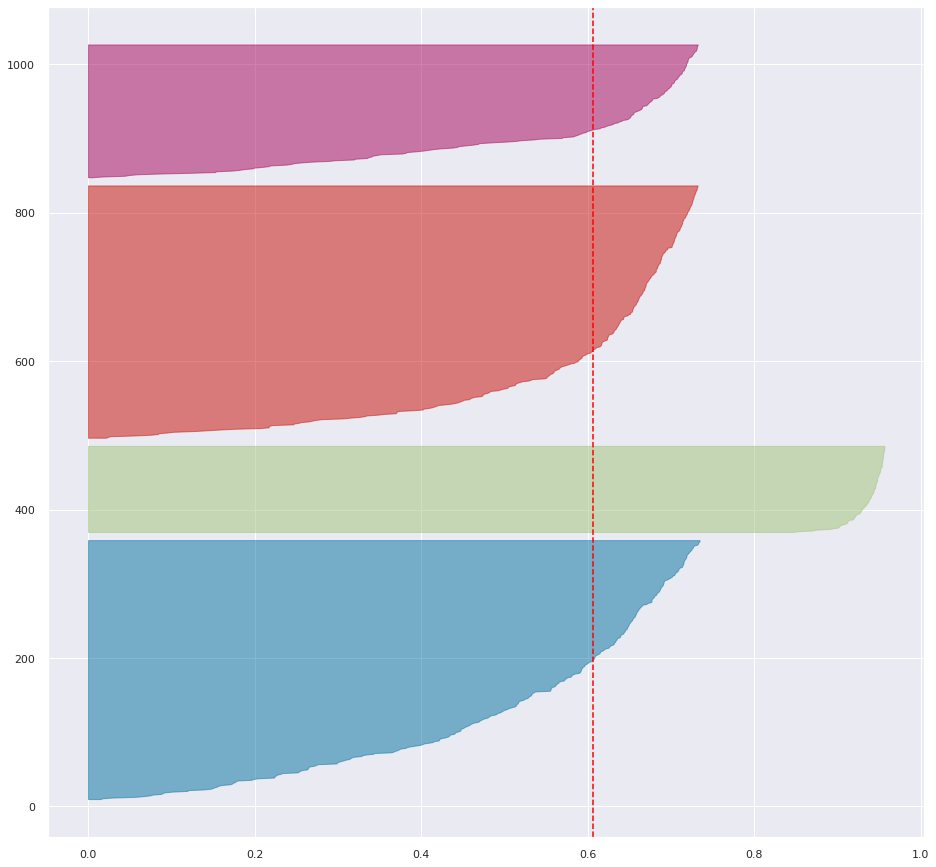

In [85]:
metricas_km_pca = statistics_model(df_clusters['ClubPosition'],df_clusters['kmeans_pca'])

from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(km_pca, colors='yellowbrick')
visualizer.fit(X_projected)


### TSNE

In [110]:
from sklearn.manifold import TSNE

In [131]:
tsne=TSNE(n_components=2) #elegimos 2, 3 o 4 pero pueden ser más, 

print(df_skills.shape)
tsne.fit(df_skills) #input data is centered but not scaled for each feature before applying the SVD

X_projected=tsne.fit_transform(df_skills) #numpy array
print ('tamaño de los datos: ', X_projected.shape)

(988, 40)
tamaño de los datos:  (988, 2)


In [132]:
# Número de clusters buscado
n_clust = 4

km_tsne = KMeans(n_clusters=n_clust)
km_tsne.fit(X_projected)

# Recuperacion de etiquetas
clusters = km_tsne.labels_
print('Suma de los cuadrados de las distancias al cluster / Inertia: ', km_tsne.inertia_)

Suma de los cuadrados de las distancias al cluster / Inertia:  97021.828125


In [133]:
df_clusters=df_wo_sub_res.copy()
df_clusters['kmeans_tsne'] = km_tsne.labels_ #clusters
print('Kmeans encontró: ', max(km_tsne.labels_)+1, 'clusters, nosotros lo forzamos')

df_clusters.groupby('kmeans_tsne').size()

Kmeans encontró:  4 clusters, nosotros lo forzamos


kmeans_tsne
0    338
1    344
2    189
3    117
dtype: int64

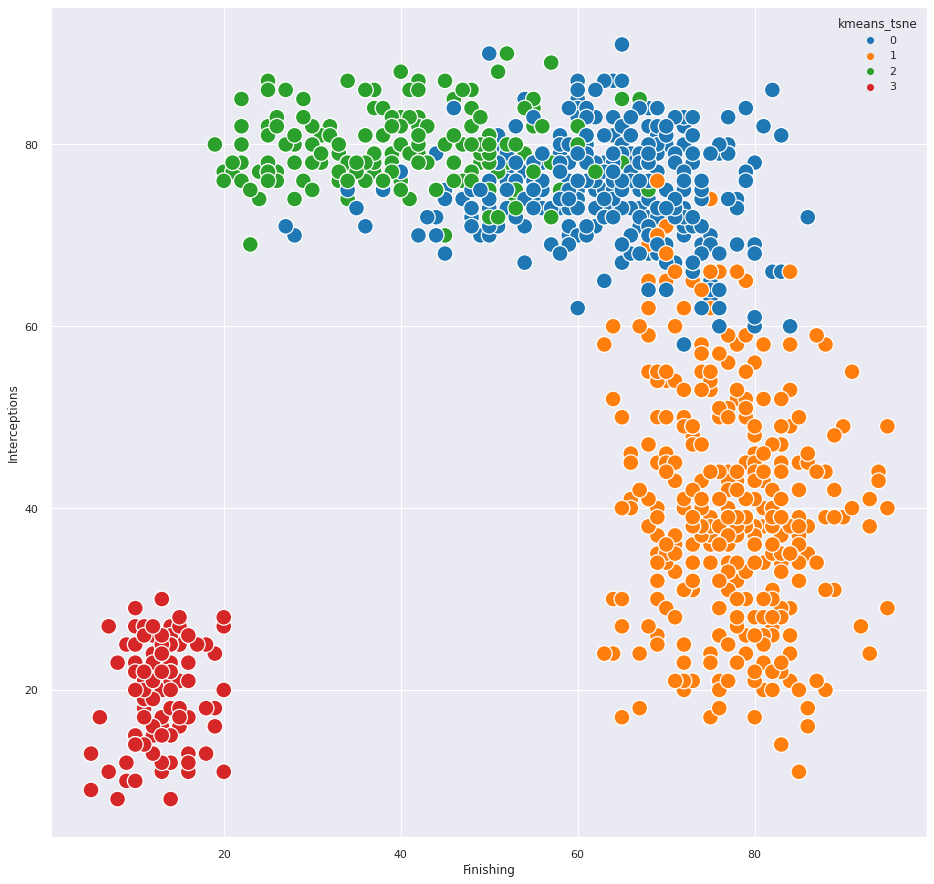

In [134]:
skill_1=skills_ratings[7]
skill_2=skills_ratings[27]
sns.scatterplot(x=skill_1,y=skill_2, hue='kmeans_tsne',data=df_clusters, s=250,palette="tab10")

Homogeneidad:	0.404
Completitud:	0.765
V Measure:	0.529


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7faa0133b050>,
                     colors='yellowbrick', estimator=KMeans(n_clusters=4))

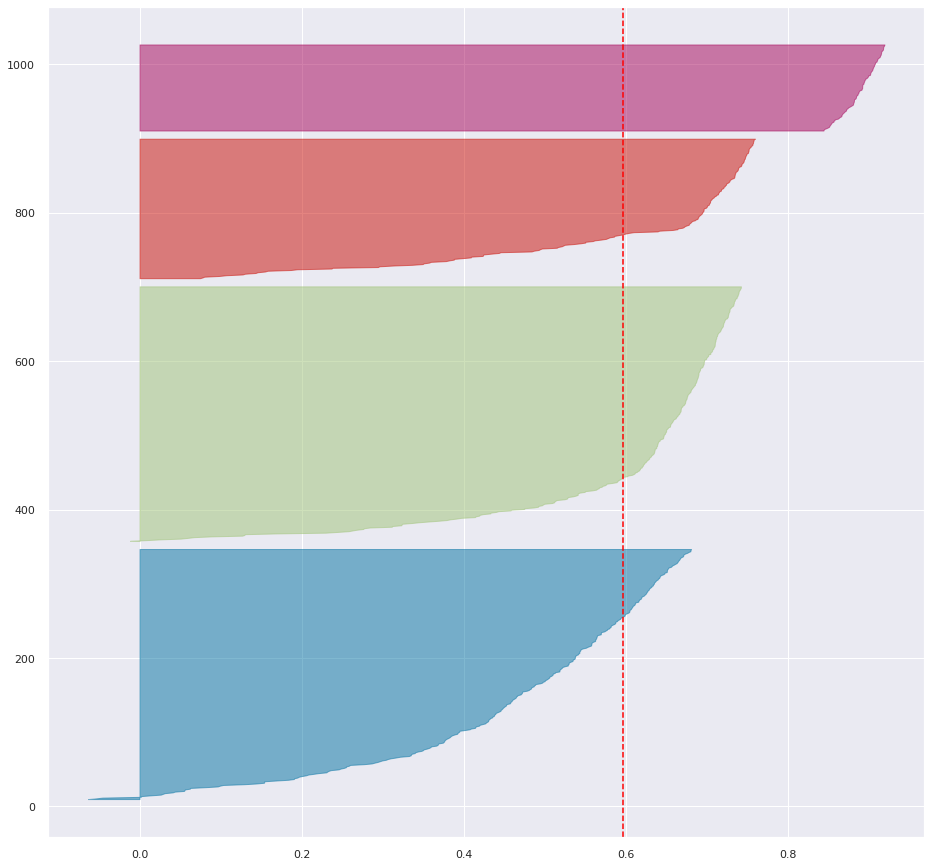

In [135]:
metricas_km_tsne = statistics_model(df_clusters['ClubPosition'],df_clusters['kmeans_tsne'])

from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(km_tsne, colors='yellowbrick')
visualizer.fit(X_projected)


### Comparación Modelos

In [130]:
print(metricas_km_tsne)
print(metricas_km_pca)
print(metricas_km)
print(metricas_sc)

(0.3868066557499765, 0.7327731521551304, 0.5063355562634773)
(0.3984442484831354, 0.7589942362366208, 0.5225623513521829)
(0.39473711033875275, 0.752131846530541, 0.5177476466076366)
(0.37469509901404713, 0.7259103685365527, 0.4942644125136916)


### Conclusión

Claramente a través de la descomposición PCA pudimos mejorar considerablemente el resultado de la clusterización del modelo. Esto se puede observar tanto en las métricas como en las siluetas. Con la técnica de descomposición TSNE mejoramos ese resultado.  
Incrementar el número de componentes principales no mejora siempre el desempeño del modelo, esto fue probado con diferentes parámetros en las técnicas SNE.  
La hipótesis planteada en la introducción pudo ser probada. Pueden clusterizarse por posición en la cancha a los jugadores según sus características. Lo más difícil es separar a los mediocampistas de delanteros y defensores, pero a través de las técnicas vistas en clases, puede encontrarse un modelo que de buenos resultados.  
Más barridos de los hiperparámetros pueden realizarse para obtener un modelo más refinado e incrementar las métricas del mismo.